# Deep Learning with PyTorch

we will use:
- PyTorch for the deep learning tools (modules, optimizers, losses, ...)
- torchvision for the computer vision architectures and datasets
- Avalanche for the multi-task streams of datasets and dynamic architectures (and later for incremental learning)

install dependencies:

In [1]:
!pip install avalanche-lib==0.5.0

^C


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\users\\w-32\\mambaforge\\envs\\791aa\\scripts\\torchrun.exe'



  Using cached avalanche_lib-0.5.0-py3-none-any.whl.metadata (12 kB)
  Using cached GPUtil-1.4.0-py3-none-any.whl
  Using cached pytorchcv-0.0.67-py2.py3-none-any.whl.metadata (133 kB)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached tqdm-4.66.2-py3-none-any.whl.metadata (57 kB)
  Using cached torchvision-0.17.1-cp310-cp310-win_amd64.whl.metadata (6.6 kB)
  Using cached torchmetrics-1.3.1-py3-none-any.whl.metadata (19 kB)
  Using cached gdown-5.1.0-py3-none-any.whl.metadata (5.7 kB)
  Using cached qpsolvers-4.3.1-py3-none-any.whl.metadata (16 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.0.1-py3-none-any.whl.metadata (4.1 kB)
  Using cached lightning_utilities-0.10.1-py3-none-any.whl.metadata (4.8 kB)
  Using cached torch-2.2.1-cp310-cp310-win_amd64.whl.metadata (26 

tested with:
- python 3.10
- avalanche 0.5

In [2]:
import torch
import avalanche
import torchvision
import matplotlib.pyplot as plt

# Dataset
first, we load the data.
- The data is automatically downloaded the first time.
- `n_experiences` defines the lenght of the stream. Today we train our model offline, so we set `n_experiences=1`

In [3]:
from avalanche.benchmarks import SplitCIFAR10
from avalanche.benchmarks import benchmark_with_validation_stream

# data is stored in $HOME/.avalanche - you can change this setting in $HOME/.avalanche/config.json
benchmark = SplitCIFAR10(n_experiences=1)
benchmark = benchmark_with_validation_stream(benchmark, validation_size=0.3)

100%|█████████████████████████████████████████████████████████████████████████████████████| 170498071/170498071 [32:00<00:00, 88790.55it/s]


Extracting D:\AVL_DATA\cifar10\cifar-10-python.tar.gz to D:\AVL_DATA\cifar10
Files already downloaded and verified


C:\Users\w-32\mambaforge\envs\791aa\lib\site-packages\avalanche\benchmarks\scenarios\supervised.py:389: UserWarning: stream generator will be converted to a list.
  warnings.warn("stream generator will be converted to a list.")


we take the data from the streams

In [4]:
train_data = benchmark.train_stream[0].dataset
valid_data = benchmark.valid_stream[0].dataset
test_data = benchmark.test_stream[0].dataset

NOTE: colors are wrong due to augmentations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'label=0')

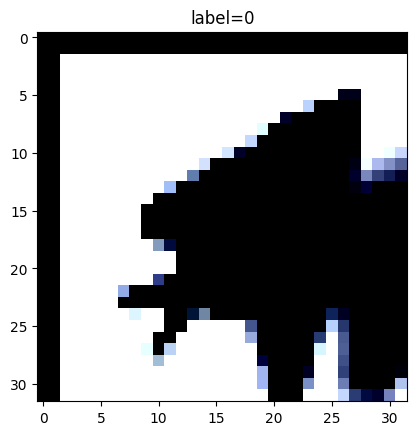

In [5]:
plt.figure()
plt.imshow(train_data[0][0].transpose(0,2).numpy())
plt.title(f"label={train_data[0][1]}")

# Dataloading

In [7]:
from torch.utils.data import DataLoader

dataloader = DataLoader(train_data, batch_size=100)
for i, (x, y, t) in enumerate(dataloader):
    # x is the input
    # y is the target class
    # t is the task label.
    # We will use it for multi-task problems
    pass
    if i == 0:
        print(f"x.shape: {x.shape}")
        print(f"y: {y}")
        print(f"t: {t}")
    if i % 100 == 0:
        print(i, end=", ")


x.shape: torch.Size([100, 3, 32, 32])
y: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
t: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
0, 100, 200, 300, 

# Model
We use a resnet18.

In [8]:
"""This is the slimmed ResNet as used by Lopez et al. in the GEM paper."""
import torch.nn as nn
from torch.nn.functional import relu, avg_pool2d
from avalanche.models import DynamicModule


class MLP(nn.Module):
    def __init__(self, sizes):
        super(MLP, self).__init__()
        layers = []
        for i in range(0, len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1]))
            if i < (len(sizes) - 2):
                layers.append(nn.ReLU())
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False,
    )


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes, nf):
        super(ResNet, self).__init__()
        self.in_planes = nf

        self.conv1 = conv3x3(3, nf * 1)
        self.bn1 = nn.BatchNorm2d(nf * 1)
        self.layer1 = self._make_layer(block, nf * 1, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, nf * 2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, nf * 4, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, nf * 8, num_blocks[3], stride=2)
        self.linear = nn.Linear(nf * 8 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        bsz = x.size(0)
        out = relu(self.bn1(self.conv1(x.view(bsz, 3, 32, 32))))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def SlimResNet18(nclasses, nf=20):
    """Slimmed ResNet18."""
    return ResNet(BasicBlock, [2, 2, 2, 2], nclasses, nf)

In [13]:
model = SlimResNet18(nclasses=10)
print(model)

ResNet(
  (conv1): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=

# Training

In [15]:
from tqdm import tqdm

device = 'cpu'  # do yourself a favor and use a gpu by setting device='cuda'
model = SlimResNet18(nclasses=10)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.04)
criterion = torch.nn.CrossEntropyLoss()

# Avalanche datasets have a training and eval mode (train/eval methods)
# to activate different augmentations
# don't forget to activate it!
train_data = train_data.train()

# Iterate over the dataset and train the model
model.train()  # don't forget to set the training mode!
for ep in range(10):  # 10 epoch is a bit on the low end. With a GPU you can run a larger experiment
    dataloader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0)  # increase num_workers if you have more CPUs
    pbar = tqdm(dataloader)
    for (x, y, _) in pbar:
        x, y = x.to(device), y.to(device)
        # the order matters!
        # - reset the gradients
        # - forward pass
        # - backward pass
        # - descent step
        optimizer.zero_grad()   
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Loss: {loss.item():0.4f}")


Loss: 0.4015: 100%|██████████████████████████████████████████████████████████████████| 469/469 [01:32<00:00,  5.09it/s]


# Evaluation

In [16]:
model = model.eval()
train_data = valid_data.eval()

dataloader = DataLoader(valid_data, batch_size=32, num_workers=0)  # increase num_workers if you have more CPUs
pbar = tqdm(dataloader)
correct, tot = 0, 0
for (x, y, _) in pbar:
    x, y = x.to(device), y.to(device)
    pred = model(x)
    _, pred = torch.max(pred.data, 1)
    correct += (pred == y).sum().item()
    tot += x.shape[0]
    pbar.set_description(f"ACC: {correct / tot:.4f}")

ACC: 0.8499: 100%|███████████████████████████████████████████████████████████████████| 469/469 [00:32<00:00, 14.34it/s]


# Exercises
Pick a couple of them to experiment with:

- **resnet**: check the ResNet code. Do you understand everything? If not, check the documentation or ask for help.
    - advanced version: now change the input transformations to change the input size of the images. Are you able to change the resnet architecture to make it compatible with the new image? Any change to the architecture is fine (just don't pad/crop the image...).
- **dataloading**: If you have a large GPU (V100/A100), you need to feed the data fast enough, otherwise you are going to waste precious GPU cycles. Transformations can be expensive and dataloaders can make a big difference in performance.
    - simple exercise: test and profile different augmentations from [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html). Play with the DataLoader parameters and measure its performance ([doc](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)). Try varying `num_workers`, `pin_memory`, and any other argument that you feel is relevant. Profile your code by timing the loading of the entire dataset in mini-batches, like you would do for a training epoch (without the forward/backward pass).
    - advanced exercise: you can also try [FFCV](https://github.com/libffcv/ffcv). Its usage is a bit more involved since you need an additional dependency and you need to prepare the dataset, but you can make the data pipeline much faster with with it.
- **augmentations matter**: try to train a model with and without augmentations.
- **training stability and lr**: try to increase the learning rate (10x, 100x, ...). What happens to the learning curve? You can also try some learning rate scheduler.
- **dropout**: as you know, dropout helps training DNN by regularizing the activations. But does it? You can try a small model such as a [SimpleMLP](https://avalanche-api.continualai.org/en/v0.3.1/generated/avalanche.models.SimpleMLP.html#avalanche.models.SimpleMLP). Does it always help? **hint**: as a general rule, if the model is too small (too shallow or not enough units), dropout will *decrease* the performance. This is a simple exercise to show you that scale matters when you make hyperparameter choices.
- **add early stopping + model checkpointing**
- **reproduce sota for CIFAR100**: use this notebook to reproduce a result from [this repo](https://github.com/weiaicunzai/pytorch-cifar100). NOTE: our resnet18 is slightly different from theirs (slim version, less units)